#TIME SERIES ANALYSIS

#Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

##DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


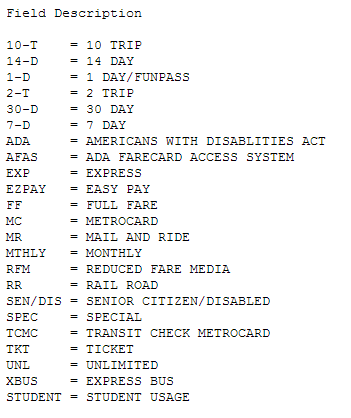

In [1]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

##note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

#Task 1: 
##Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
##Identify it and figure out what it is due to.


#Task 2: 
##Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


#Task 3:
##Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


#EXTRA CREDIT: Cluster. 
##Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
##Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

##i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T

##removing empty light curves
tots = tots[tots.std(1)>0]

##with Kmeans you have to choose the number of clusters ahead km = 

KMeans(n_clusters=10)

##and standardize the lightcurves before clustering
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

##then you can run:

km.fit(vals)

#HINTS: 

##When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average)


#Possibly useful functions

##I used a variety of functions, most of them you are familiar with already. here are a few that you may not have encountered yet which I used. 
##(But you do not have to use them! there are many ways to do things and you do not have to solve this problem like I did)

* the numpy function np.where() returns the index where a condition is true. it is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. if you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft  
     
     np.fft.rfft(mydata) 
     
     will return the fourier transform, but what you want is its absolute value: np.abs(). Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

     np.fft.rfftfreq(N, d) 
     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the Sample spacing, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1)


*  the np.array.flatten() and np.array.reshape() allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which i recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series)



In [2]:
import numpy as np
mta_raw = np.load("MTA_Fare.npy")

In [3]:
#after reading the datacube you should see:
mta_raw.shape

(600, 23, 194)

In [4]:
mta = mta_raw.astype(float)

In [5]:
mta.dtype

dtype('float64')

In [6]:
# Convert the swipe numbers value which is -1 to NaN
def canconvert(mydata):
    if mydata == -1:
        return True
    else:
        return False  

In [7]:
vfunc = np.vectorize(canconvert)
indx = vfunc(np.array(mta_raw))
mta[indx] = float('NaN') 

ride types list

In [8]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [9]:
#after I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

In [10]:
import pandas as pd
week_range = pd.date_range(start='20100601',periods = 194, freq='7D')
week_range

DatetimeIndex(['2010-06-01', '2010-06-08', '2010-06-15', '2010-06-22',
               '2010-06-29', '2010-07-06', '2010-07-13', '2010-07-20',
               '2010-07-27', '2010-08-03', 
               ...
               '2013-12-10', '2013-12-17', '2013-12-24', '2013-12-31',
               '2014-01-07', '2014-01-14', '2014-01-21', '2014-01-28',
               '2014-02-04', '2014-02-11'],
              dtype='datetime64[ns]', length=194, freq='7D', tz=None)

In [11]:
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


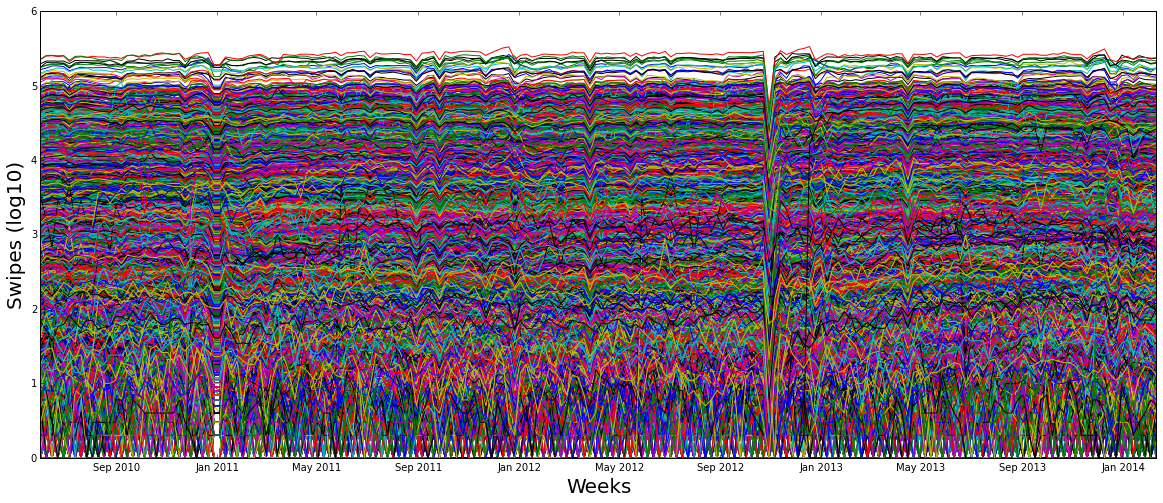

In [12]:
fig = figure(figsize=(20,8))
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        pl.plot(np.array(week_range)[0:194],np.log10(mta[i][j]))
pl.xlabel("Weeks", fontsize=20)
pl.ylabel("Swipes (log10)", fontsize=20)

# Trend Detection

In [13]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations to get 23 time series, one per ridership type
print (mta.shape)
mta_allsum = np.nansum(mta, axis=0)
print (mta_allsum.shape)
#sum time series for all ride types to get 600 time series,one per station
mta_allsum_ride_types = np.nansum(mta, axis=1)
print (mta_allsum_ride_types .shape)

(600, 23, 194)
(23, 194)
(600, 194)


##NOTE ON THE TREND DETECTION:
###you should find the ride type that has the steepest increase, and the steepest decrease. notice: we are looking for something that has a more or less constant trend

###to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

###you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the flux near the beginning to the flux near the end of the time series.

###notice that you should inspect the time series, either algorithmically or by eye, to ensure you see a trend, and not just changing structure.


###below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

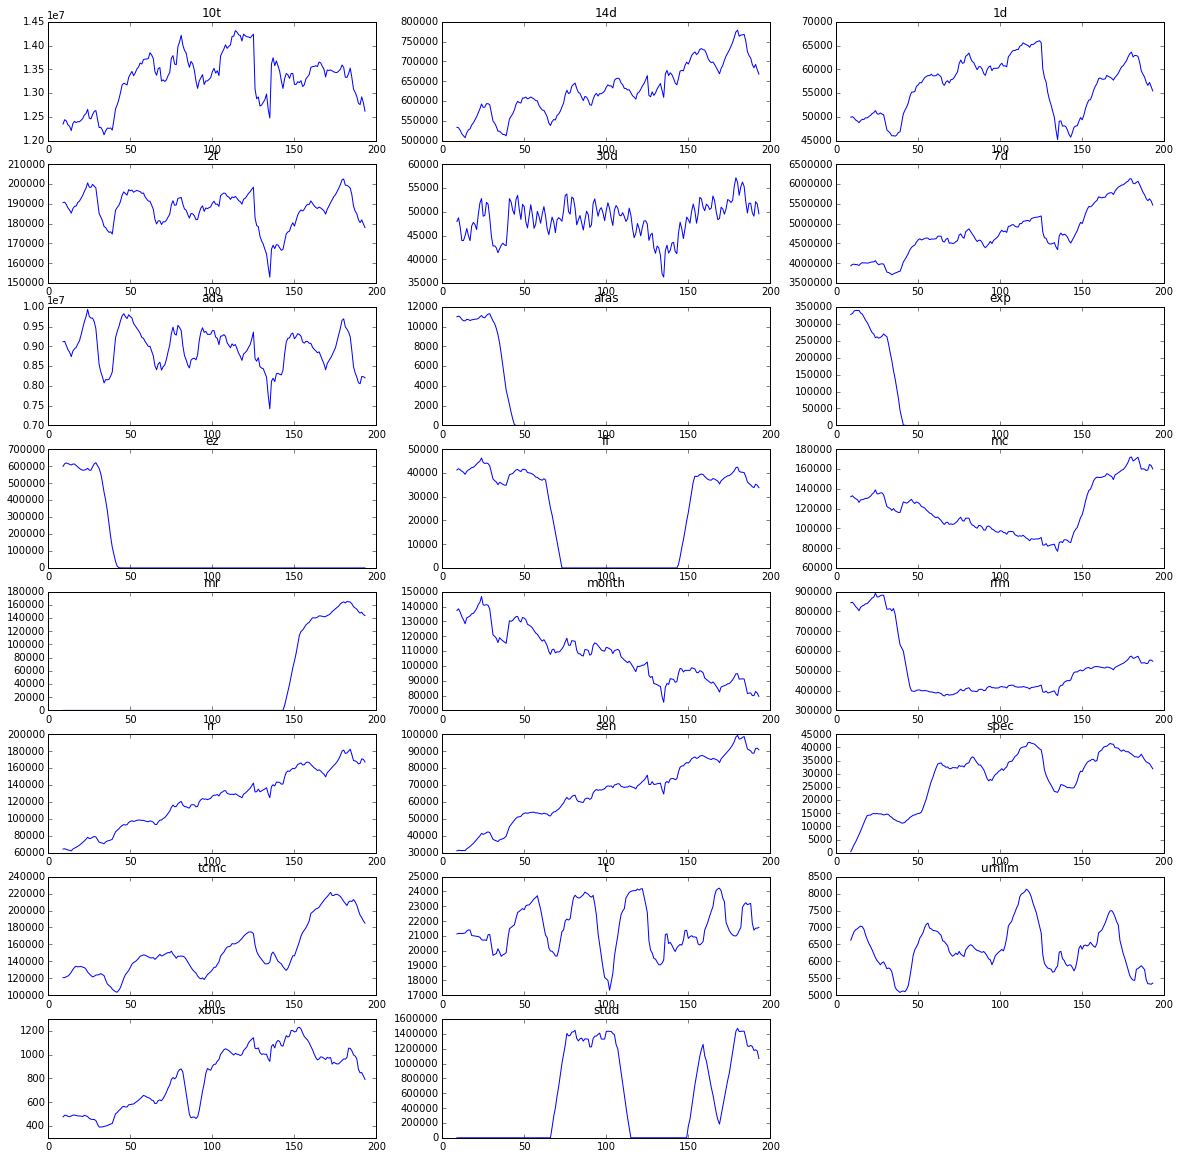

In [14]:
flux_ratio = np.zeros(23)
std = np.zeros(23)
fig = plt.figure(figsize=(20,20))
for i in range(23):
    ax = fig.add_subplot(8,3,i+1)
    rolling_mean = pd.rolling_mean(mta_allsum[i,:], 10)
    flux_ratio[i] = rolling_mean[9]/rolling_mean[193]
    std[i] = np.nanstd(rolling_mean)
    plt.plot(rolling_mean)
    ax.set_title(ridetype[i])

In [21]:
ridetype_ratio_std = pd.DataFrame({'Type' : ridetype,'Flux Ratio From Beginning to End' : flux_ratio,'Std' : std})

In [22]:
ridetype_ratio_std

,Flux Ratio From Beginning to End,Std,Type
0,0.978667,546777.616992,10t
1,0.798681,64593.901400,14d
2,0.899810,5767.412494,1d
3,1.070889,8828.003856,2t
4,0.967317,3624.088526,30d
5,0.719555,631955.017784,7d
6,1.111307,473487.373171,ada
7,4774.478261,3794.926774,afas
8,93571.342857,101444.891854,exp
9,665798.555556,206370.776156,ez


##to determine if there is a trend or strucutre you can inspect the time series visually, since there are only 23!
##an alternative, algorithmic way to do it, is to fit a line to the (smoothed) time series  and look at the residuals.

### My comment:

As shown in the graphs above, there is a increasing trend in ride type '14d','7d','ff','sen' and there is a decreasing trend in ride type 'month'.

# Event Detection

Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Identify it and figure out what it is due to.

In [17]:
# Find out the week index of prominent events
all_events = []
for i in range(23):
    threshold = mta_allsum[i].mean() - 3*mta_allsum[i].std()
    event = (mta_allsum[i] < threshold)
    event_index = [m for m, n in enumerate(event) if n == True]
    for j in range(len(event_index)):
        all_events.append(event_index[j])

In [18]:
total_event_index = pd.DataFrame({'event_index':all_events})

In [19]:
# Select the most prominent one's index
total_event_index['event_index'].value_counts()

126    12
189     2
173     2
31      1
95      1
30      1
134     1
dtype: int64

In [23]:
# Identify the week
prominent_event_week = week_range[126]
print prominent_event_week

2012-10-30 00:00:00


### My Comment:
So, the extreme drop of MTA swipes happened during the week of October 30, 2012. It should be caused by the Hurricane Sandy which made the MTA service interrupt.

# Periodicity

In [ ]:
#this is a "power spectrum": the plot of the absolute value of the fourier transform. 
#I changed the xtick labels from frequecy (1/week) to period (in weeks)
#to facilitate the visual identification of the 1-year period peak
#(notice however that np.fft.rfftfreq(N, d)  returns frequency)

In [ ]:
#and here is one of he periodic time series you should find by identifying the time series with the most power 
#at 1/52 weeks frequency in fourier space

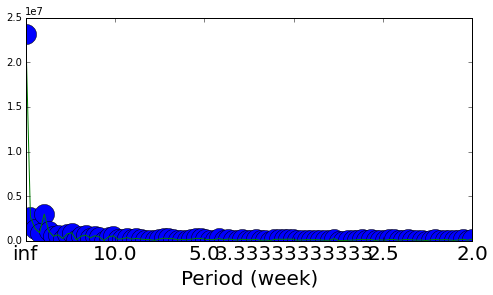

In [26]:
# Test
N = 194
f = np.abs(np.fft.rfft(mta_allsum_ride_types[0]))
fig=pl.figure(figsize=(8,4))
ax=fig.add_subplot(111)
ax.plot(np.fft.rfftfreq(N, 1.0), (f), 'o', ms=20)
ax.plot(np.fft.rfftfreq(N, 1.0), (f), '-')
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("Period (week)", fontsize=20)

[  inf  194.]
[ 2.04210526  2.02083333]


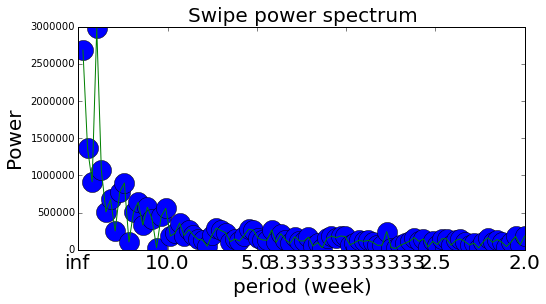

In [27]:
f = np.abs(np.fft.rfft(mta_allsum_ride_types[0]))
fig = pl.figure(figsize=(8,4))
ax = fig.add_subplot(111)
print (1.0/np.fft.rfftfreq(N, 1.0)[0:2])
print (1.0/np.fft.rfftfreq(N, 1.0)[-3:-1])
ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=20)
ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("period (week)", fontsize=20)
pl.ylabel("Power", fontsize=20)
pl.title("Swipe power spectrum", fontsize=20)

In [28]:
# Find the index of the frequency which is closest to 1/52 weeks.
freq = np.fft.rfftfreq(N, 1.0)
index_52week = max([m for m, n in enumerate(freq) if n <= 1.0/52])
print 1.0/freq[index_52week]
index_52week += 1
print 1.0/freq[index_52week]

64.6666666667
48.5


In [29]:
f = np.abs(np.fft.rfft(mta_allsum_ride_types[0]))
f[index_52week]

2980160.6355953491

In [30]:
power = []
power_2 = []
for i in range(600):
    f = np.abs(np.fft.rfft(mta_allsum_ride_types[i,:]))
    power.append(f[index_52week])
    power_2.append(f[index_52week])

In [31]:
power_2.sort(reverse=True)

In [32]:
station_most_power = [m for m, n in enumerate(power) if n == 2980160.6355953491 or n == 2950388.929214194 or n == 2931895.8769513383 or n ==2402218.5809588572]

In [33]:
print station_most_power

[0, 150, 194, 327]


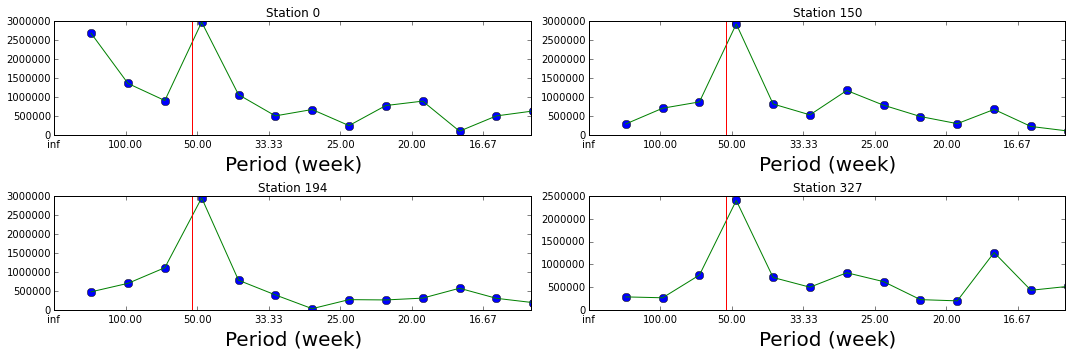

In [34]:
fig = pl.figure(figsize=(15,5))
j = 1
for i in station_most_power:
    ax = fig.add_subplot(2,2,j)
    f = np.abs(np.fft.rfft(mta_allsum_ride_types[i,:]))
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f)[1:], 'o', ms=8)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f)[1:], '-')
    ax.set_xlim(0,1.0/15)
    ax.set_xticklabels([ "%.2f"%(1/f) for f in ax.get_xticks()], fontsize=10)
    pl.xlabel("Period (week)", fontsize=20)
    plt.axvline(1.0/52,c='r')
    j += 1
    ax.set_title('Station %i' % i)
fig.tight_layout()

### My comment:
From the Fourier Analysis, we can find that station 0,150,194 and 327 have the most prominent annual periodicity.